In [1]:
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
####  Mouse C3KO-RichLi scRNA
####  2023-05-18 by Yi Zhao (Texas Heart Institute, US)
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
####  Ver <- '0'
####  Step <- 'PART06_scVI'
####  Project <- '2023_hos_dturaga'

In [2]:
import torch
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import scvi

Global seed set to 0
/home/yzhao/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/yzhao/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
sc.set_figure_params(figsize=(8, 8))

In [4]:
adata = sc.read_h5ad('/moria/2023_NeoC3KO_RLi/rdata/mouse_v0/integrated/PART06.merged.clean_cbn.ann.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 101635 × 27993
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample', 'orig.name', 'study', 'method', 'platform', 'protocol', 'processed', 'tissue', 'enrichment', 'genotype', 'condition', 'sex', 'age', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'pct_mito_RNA', 'group1', 'group2', 'data_process', 'LowQual', 'Doublet_SC', 'Doublet_SC_score'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_hmn_umap'

In [6]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [7]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample"
)

In [8]:
# run PCA then generate UMAP plots
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

In [9]:
adata.obsm['X_pcaumap']=adata.obsm['X_hmn_umap']

In [10]:
adata.write_h5ad(filename='/moria/2023_NeoC3KO_RLi/rdata/mouse_v0/integrated/PART06.tmp.h5ad')

In [11]:
adata=sc.read_h5ad('/moria/2023_NeoC3KO_RLi/rdata/mouse_v0/integrated/PART06.tmp.h5ad')

/home/yzhao/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


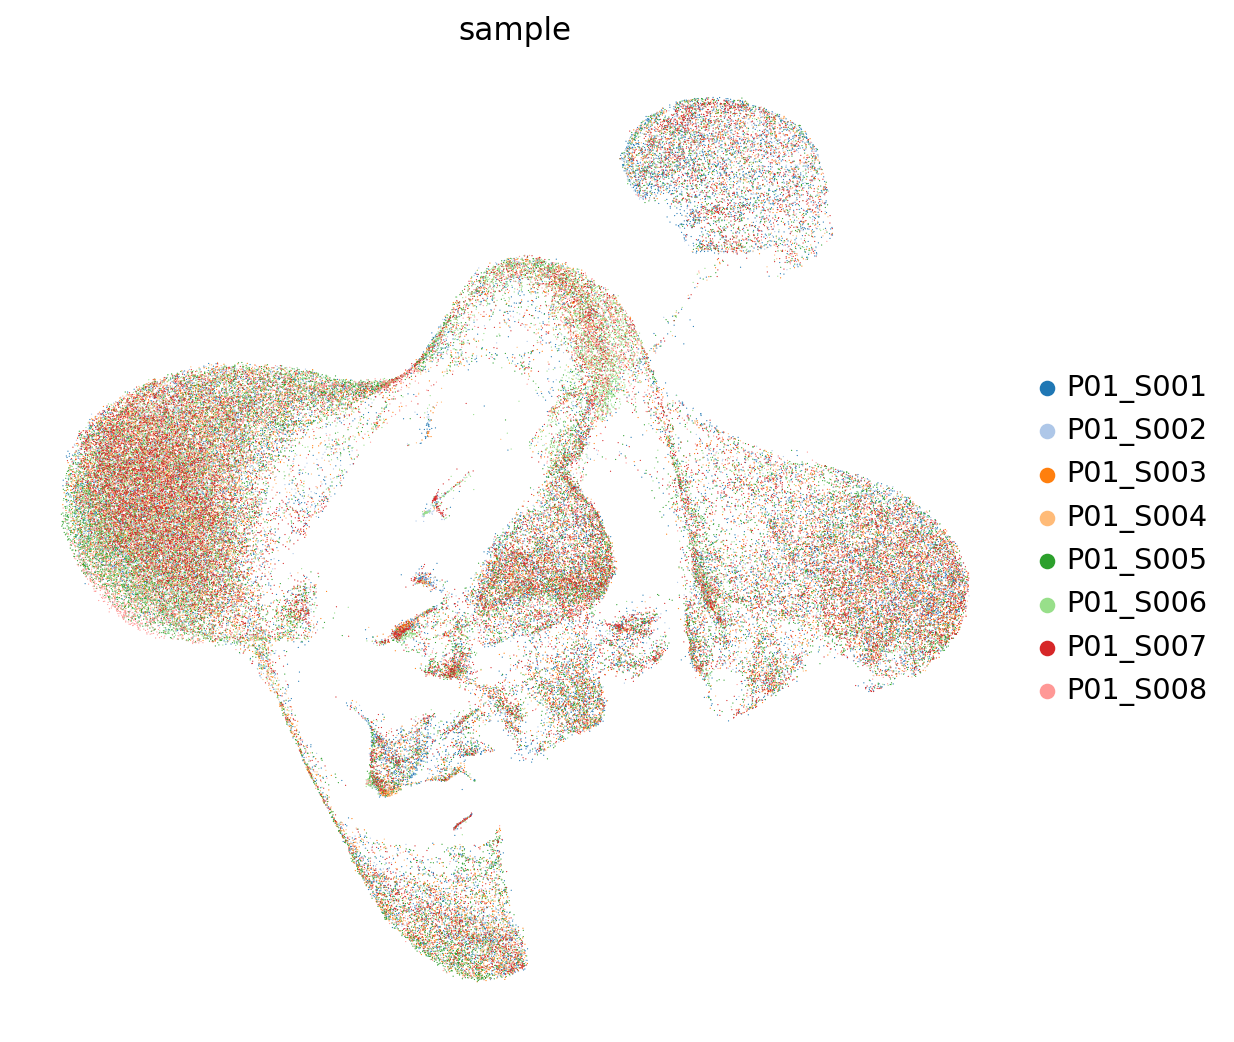

In [12]:
sc.pl.embedding(
    adata, 
    palette=sc.pl.palettes.vega_20,
    basis='pcaumap',
    color=["sample"],
    frameon=False,
)

In [13]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key='sample',
#    categorical_covariate_keys=['donor'],
    continuous_covariate_keys=["pct_mito_RNA", "nCount_RNA", "nFeature_RNA"]
)


In [14]:
## Creating and training a model
model = scvi.model.SCVI(adata, n_layers=2, n_latent=50)
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [15]:
# scvi.data.view_anndata_setup(model.adata)

In [16]:
model.train(max_epochs=400)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [42:42<00:00,  6.45s/it, loss=606, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [42:42<00:00,  6.41s/it, loss=606, v_num=1]


In [17]:
## Obtaining model outputs
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent
adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size=10e4)

In [18]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
adata.obsm['X_scVIumap']=adata.obsm['X_umap']

/home/yzhao/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


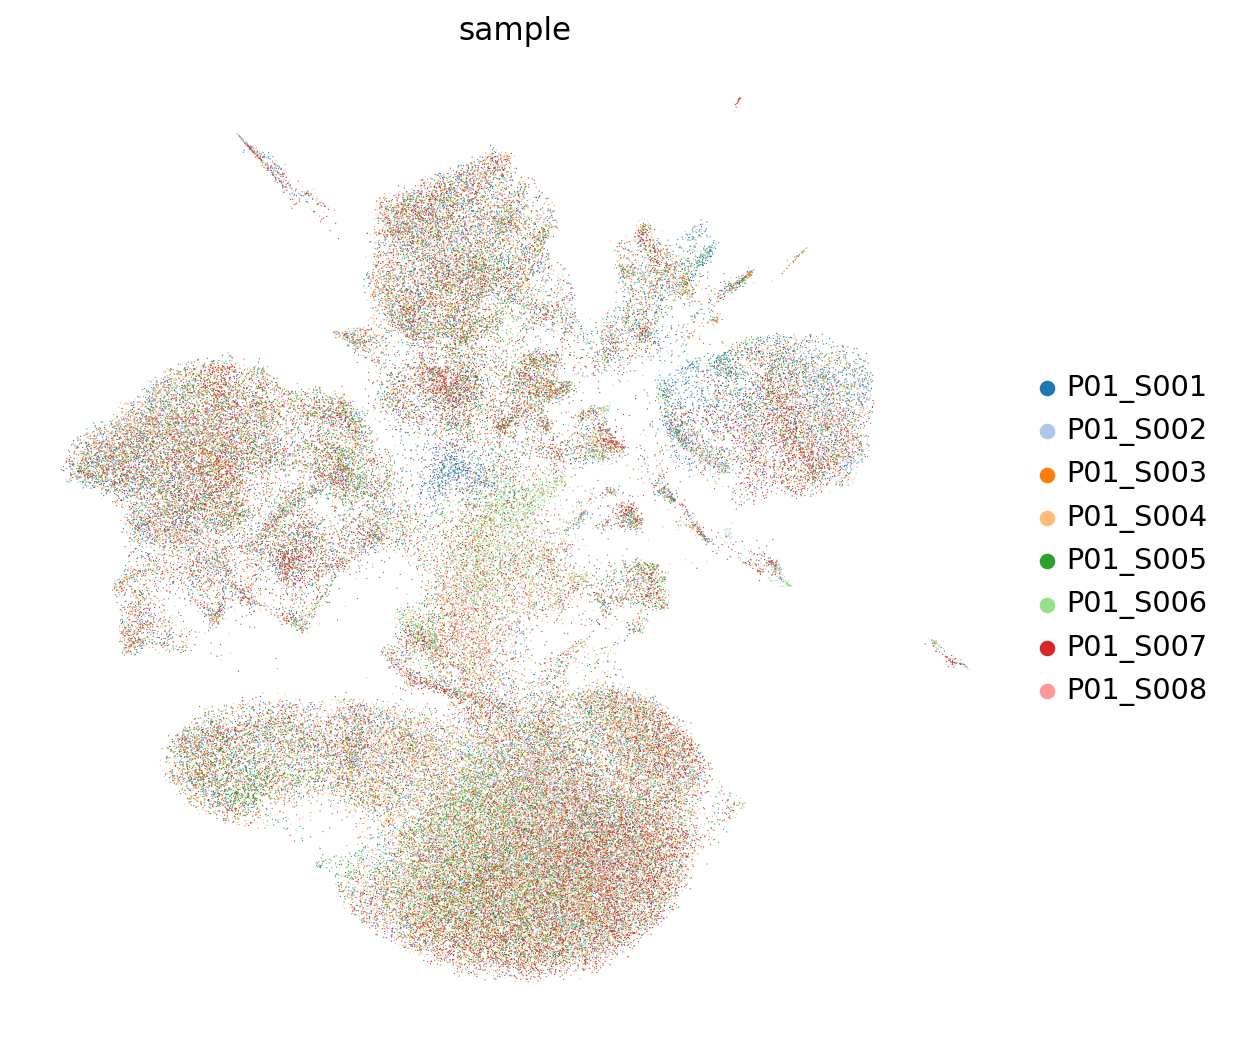

In [19]:
sc.pl.embedding(
    adata, 
    palette=sc.pl.palettes.vega_20,
    basis='scVIumap',
    color=["sample"],
    frameon=False,
)

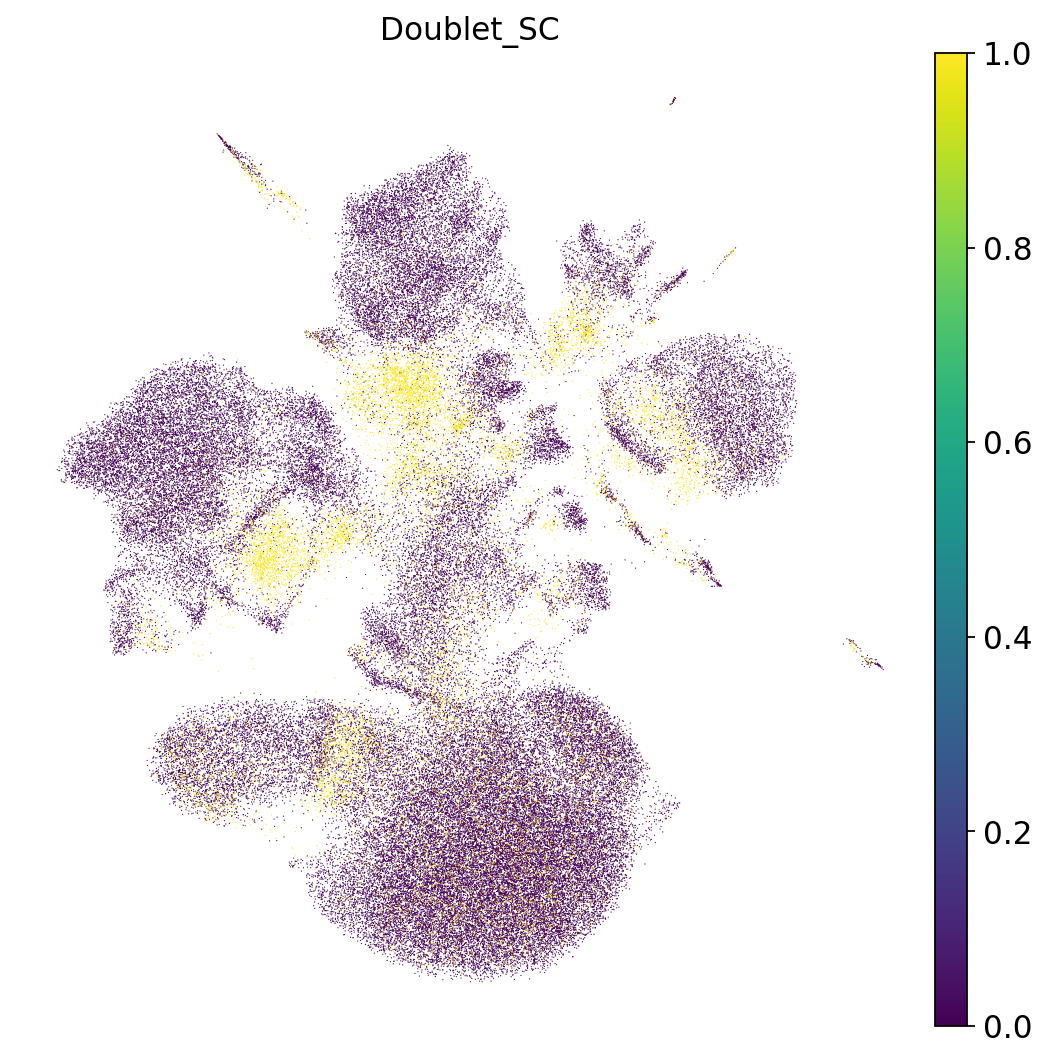

In [20]:
sc.pl.embedding(
    adata, 
    palette=sc.pl.palettes.vega_10,
    basis='scVIumap',
    color=["Doublet_SC"],
    frameon=False,
)

In [21]:
model.save("/moria/2023_NeoC3KO_RLi/rdata/mouse_v0/integrated/PART06.scvi_integration_model")

In [22]:
adata.write_h5ad(filename='/moria/2023_NeoC3KO_RLi/rdata/mouse_v0/integrated/PART06.scvi_integration.h5ad')

In [23]:
# adata = sc.read_h5ad('/lorien/hlhs/rdata/human_v0/integrated/PART07.scvi_integration.h5ad')

In [24]:
adata = sc.read_h5ad('/moria/2023_NeoC3KO_RLi/rdata/mouse_v0/integrated/PART06.scvi_integration.h5ad')

In [25]:
## Clustering the neighborhood graph
sc.tl.leiden(adata, resolution = 1.5, key_added = 'Cluster_leiden_res1.5')
sc.tl.leiden(adata, resolution = 1, key_added = 'Cluster_leiden_res1.0')
sc.tl.leiden(adata, resolution = 0.8, key_added = 'Cluster_leiden_res0.8')
sc.tl.leiden(adata, resolution = 0.5, key_added = 'Cluster_leiden_res0.5')
sc.tl.leiden(adata, resolution = 0.2, key_added = 'Cluster_leiden_res0.2')

/home/yzhao/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yzhao/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yzhao/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yzhao/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yzhao/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No d

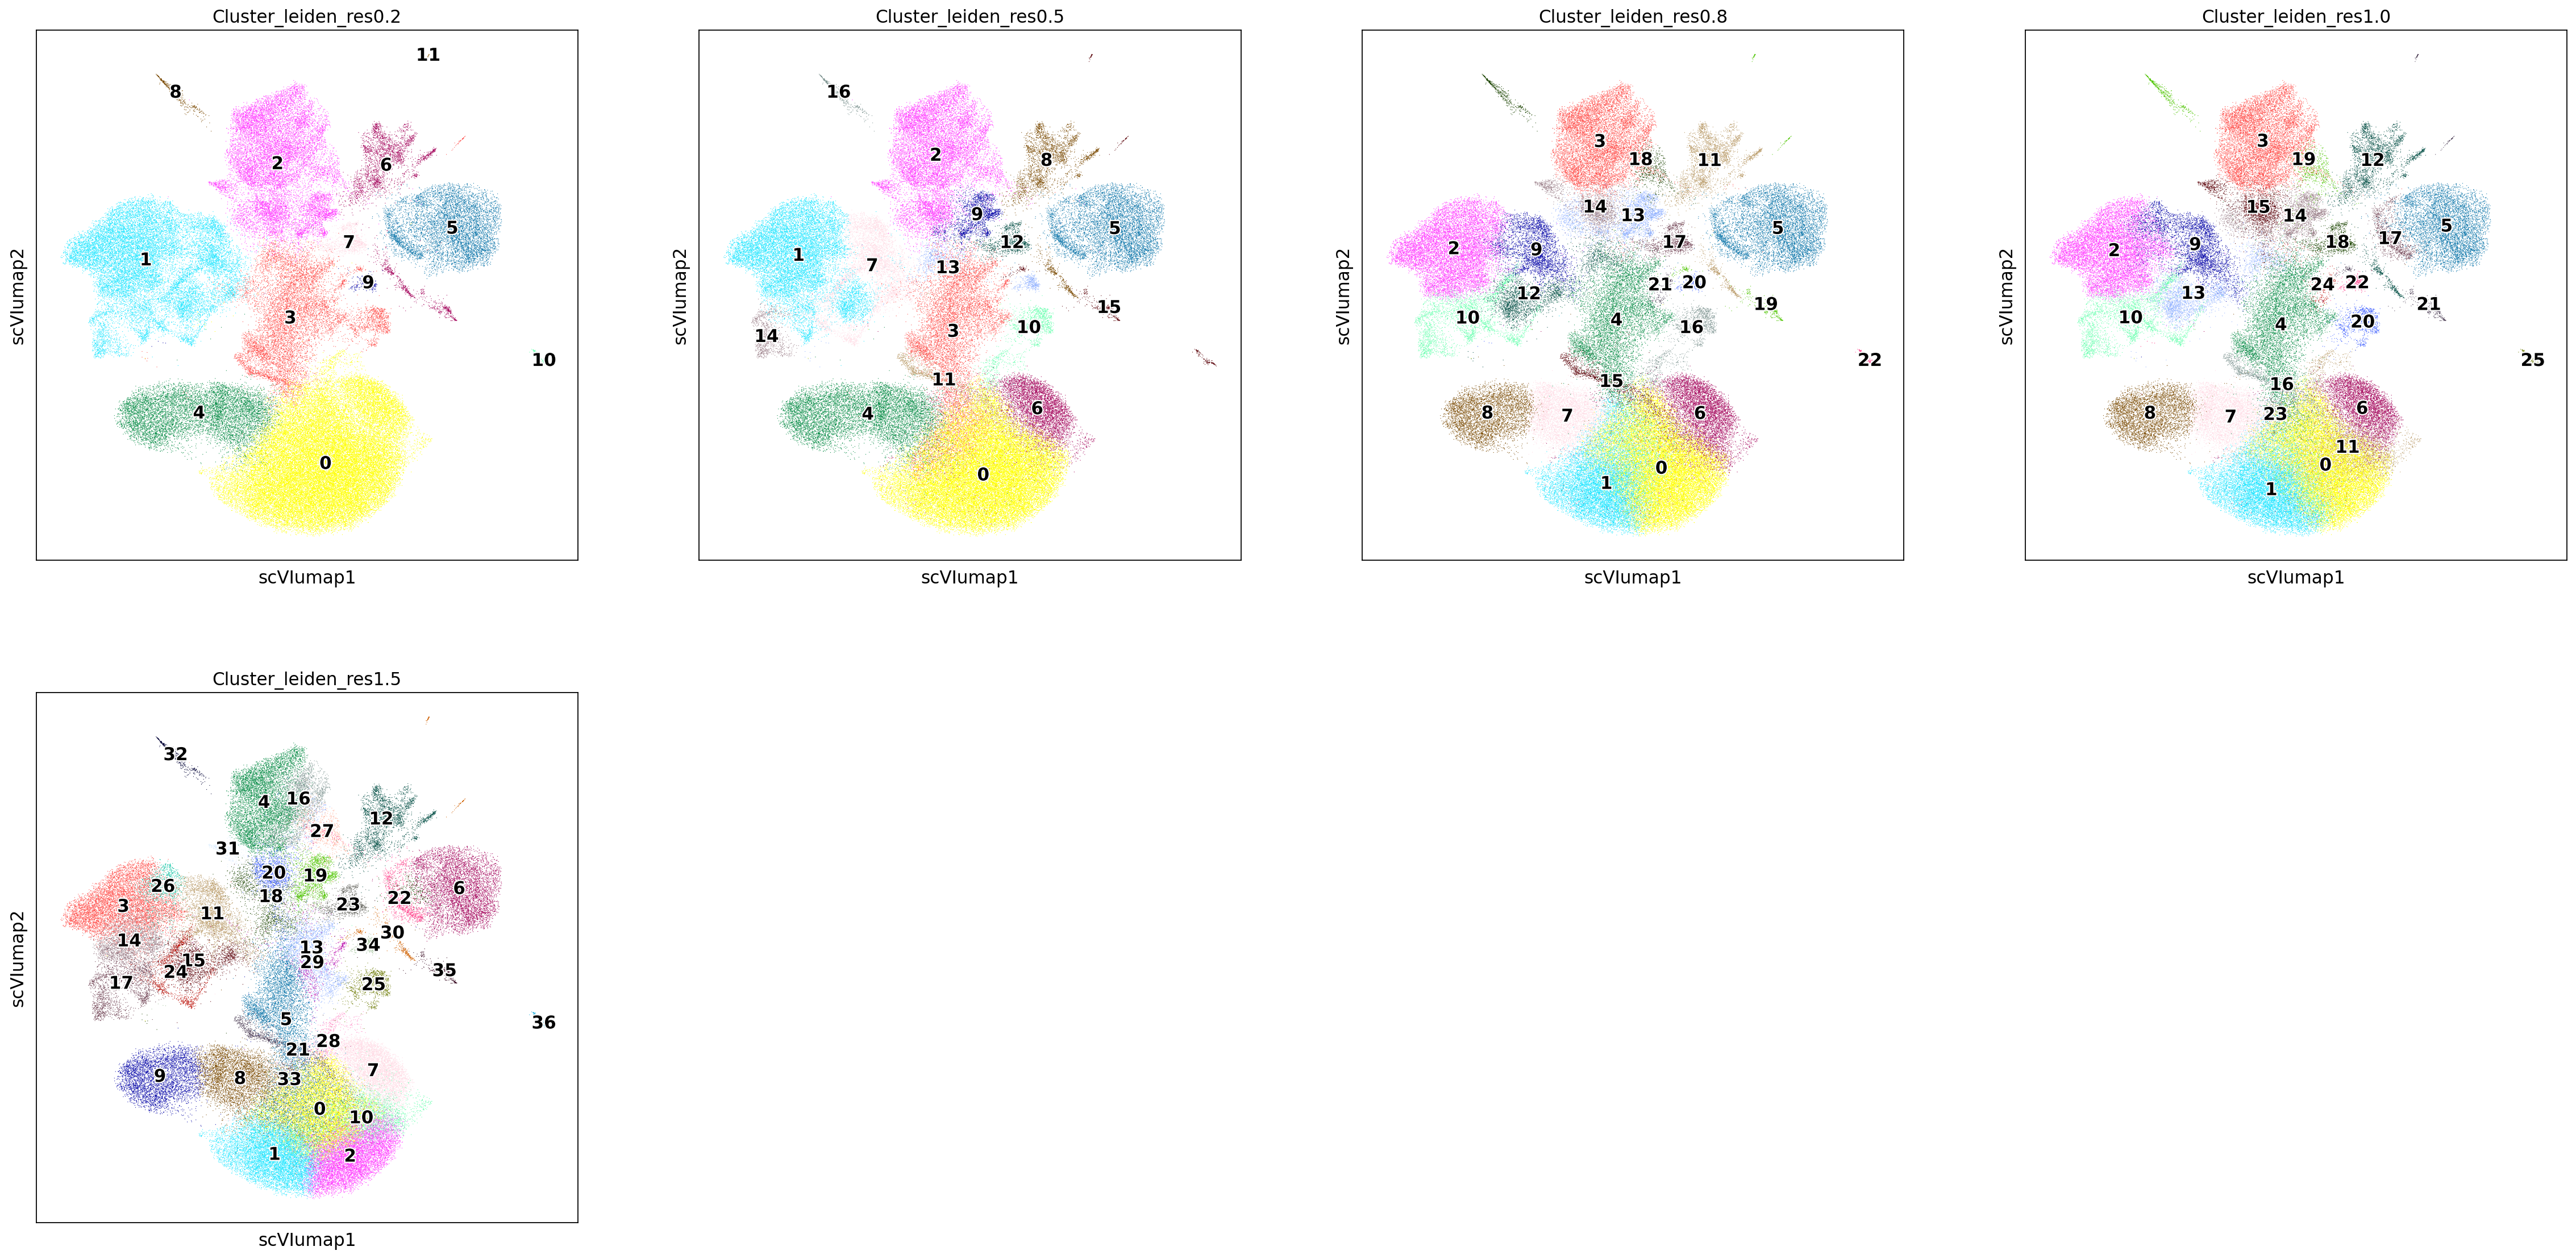

In [26]:
sc.pl.embedding(
    adata, 
    palette=sc.pl.palettes.default_102,
    add_outline=False, 
    legend_loc='on data',
    legend_fontoutline=2,
    basis='scVIumap',
    color=['Cluster_leiden_res0.2',
           'Cluster_leiden_res0.5', 
           'Cluster_leiden_res0.8', 
           'Cluster_leiden_res1.0',
           'Cluster_leiden_res1.5']
)

In [27]:
adata

AnnData object with n_obs × n_vars = 101635 × 3000
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample', 'orig.name', 'study', 'method', 'platform', 'protocol', 'processed', 'tissue', 'enrichment', 'genotype', 'condition', 'sex', 'age', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'pct_mito_RNA', 'group1', 'group2', 'data_process', 'LowQual', 'Doublet_SC', 'Doublet_SC_score', '_scvi_batch', '_scvi_labels', 'Cluster_leiden_res1.5', 'Cluster_leiden_res1.0', 'Cluster_leiden_res0.8', 'Cluster_leiden_res0.5', 'Cluster_leiden_res0.2'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap', 'leiden', 'Cluster_leiden_res0.2_colors', 'Cluster_leiden_res0.5_colors', 'Cluster_leiden_res0.8_colors', 'Cluster_leiden_res1.0_colors', 'Cluster_

In [28]:
adata_bkp = adata

In [29]:
# adata.var.rename(columns = {'_index':'XXX'}, inplace = True) ## bug workaround

In [30]:
adata.write_h5ad(filename='/moria/2023_NeoC3KO_RLi/rdata/mouse_v0/integrated/PART06.scvi_integration.h5ad')

In [31]:
## in case the h5ad cannot be loaded back into R due to bugs
adata = sc.read_h5ad('/moria/2023_NeoC3KO_RLi/rdata/mouse_v0/integrated/PART06.scvi_integration.h5ad')

In [32]:
del adata.layers["scvi_normalized"]
del adata.layers["counts"]
del adata.raw
del adata.uns
del adata.obsp
del adata.varm
del adata.var
del adata.obsm['X_pca']
del adata.obsm['X_pcaumap']
del adata.obsm['X_umap']
#del adata.obsm['_scvi_extra_categorical_covs']
del adata.obsm['_scvi_extra_continuous_covs']
adata

AnnData object with n_obs × n_vars = 101635 × 3000
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample', 'orig.name', 'study', 'method', 'platform', 'protocol', 'processed', 'tissue', 'enrichment', 'genotype', 'condition', 'sex', 'age', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'pct_mito_RNA', 'group1', 'group2', 'data_process', 'LowQual', 'Doublet_SC', 'Doublet_SC_score', '_scvi_batch', '_scvi_labels', 'Cluster_leiden_res1.5', 'Cluster_leiden_res1.0', 'Cluster_leiden_res0.8', 'Cluster_leiden_res0.5', 'Cluster_leiden_res0.2'
    obsm: 'X_hmn_umap', 'X_scVI', 'X_scVIumap'

In [33]:
adata.write_csvs(dirname='/moria/2023_NeoC3KO_RLi/rdata/mouse_v0/integrated/STEP06.scanvi_integration.csvs', sep=",")

In [34]:
## The End